In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/pheme/pheme-dataset.csv'
df = pd.read_csv(path)
df.head(5)

path = '/content/drive/MyDrive/Fakenews/train.csv'
test_df = pd.read_csv(path)
test_df['label'] = test_df['label'].apply(lambda x: 1 if x == 0 else 0)
retain_size = int(len(df) *0.25)
test_df = test_df.sample(n=retain_size, random_state=42)
test_df.reset_index(drop=True, inplace=True)

glove_file_path = '/content/drive/MyDrive/glove/glove.6B.100d.txt'



Mounted at /content/drive


In [2]:
print(df.shape)
df.isna().sum()

(1705, 3)


Unnamed: 0    0
text          0
target        0
dtype: int64

In [3]:
print(test_df.shape)
test_df.isna().sum()

(426, 5)


id         0
title     10
author    42
text       0
label      0
dtype: int64

In [4]:
from sklearn.utils import shuffle

df = df[~df['text'].isna()][['text','target']]
test_df = test_df[~test_df['title'].isna()][['title','label']]
# Shuffle
df = shuffle(df).reset_index(drop=True)
test_df = shuffle(test_df).reset_index(drop=True)
df.drop_duplicates(subset=['text'],keep='first',inplace=True)
test_df.drop_duplicates(subset=['title'],keep='first',inplace=True)

In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
list_of_words = []

for title in df['text'].dropna():
    title = re.sub(r'http\S+', '', title)
    title = re.sub(r'www\S+', '', title)
    word = re.sub('[^a-zA-Z]', ' ', title)
    word = word.lower()
    word = word.split()
    word = [lemmatizer.lemmatize(w) for w in word if not w in stop_words]
    word = ' '.join(word)
    list_of_words.append(word)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
unique_words = list(set(word for sentence in list_of_words for word in sentence.split()))
voc_size = len(unique_words)

In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
test_list_of_words = []

for title in test_df['title'].dropna():
    title = re.sub(r'http\S+', '', title)
    title = re.sub(r'www\S+', '', title)
    word = re.sub('[^a-zA-Z]', ' ', title)
    word = word.lower()
    word = word.split()
    word = [lemmatizer.lemmatize(w) for w in word if not w in stop_words]
    word = ' '.join(word)
    test_list_of_words.append(word)

In [8]:
test_unique_words = list(set(word for sentence in test_list_of_words for word in sentence.split()))
test_voc_size = len(test_unique_words)

In [9]:
titles = [text for text in list_of_words]
max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

test_titles = [text for text in test_list_of_words]
test_max_len = 0
test_titles_len = []
for title in test_titles:
    test_titles_len.append(len(title.split()))
    test_max_len = max(len(title.split()), test_max_len)

max_len=max(max_len,test_max_len)
print('Max length of the titles:', max_len)

Max length of the titles: 26


In [10]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words
voc_size = test_voc_size + voc_size
train_df, val_df = train_test_split(df, test_size=0.125, random_state=42)

train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(train_df['text'])
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
val_sequences = tokenizer.texts_to_sequences(val_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['title'])

max_length = max_len  
padding_type = 'post'
truncating_type = 'post'

padded_train = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)
padded_val = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)
padded_test = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)
x_train, x_val, x_test = padded_train, padded_val, padded_test
y_train, y_val, y_test = train_df['target'], val_df['target'], test_df['label']

In [11]:

def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index
glove_embeddings = load_glove_embeddings(glove_file_path)

def create_embedding_matrix(tokenizer, embeddings_index, embedding_dim):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

embedding_matrix = create_embedding_matrix(tokenizer, glove_embeddings, 100)

# **LSTM**

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.regularizers import l2
## Creating model Using LSTM
voc_size = embedding_matrix.shape[0]
embedding_vector_features=100
model=Sequential()
model.add(Embedding(voc_size, output_dim=embedding_vector_features, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


Epoch 1/3
24/24 [==============================] - 10s 27ms/step - loss: 0.6638 - accuracy: 0.6272 - val_loss: 0.5961 - val_accuracy: 0.7418
Epoch 2/3
24/24 [==============================] - 0s 6ms/step - loss: 0.5642 - accuracy: 0.7180 - val_loss: 0.4802 - val_accuracy: 0.7840
Epoch 3/3
24/24 [==============================] - 0s 6ms/step - loss: 0.4982 - accuracy: 0.7719 - val_loss: 0.4142 - val_accuracy: 0.8263


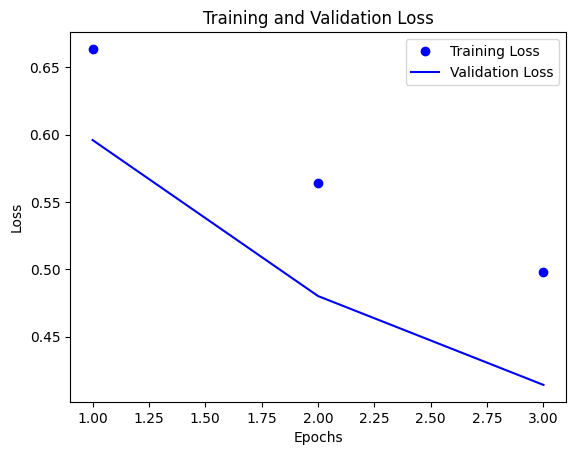

In [13]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 3)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

13/13 [==============================] - 1s 2ms/step
LSTM Model Accuracy :  0.5721153846153846
Precision :  0.5572289156626506
Recall :  0.8564814814814815
F1 :  0.6751824817518248
G-mean: 0.4764111591814287
Training time:  10.263320207595825
Inference time:  0.6831159591674805
              precision    recall  f1-score   support

           0       0.63      0.27      0.37       200
           1       0.56      0.86      0.68       216

    accuracy                           0.57       416
   macro avg       0.59      0.56      0.52       416
weighted avg       0.59      0.57      0.53       416



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


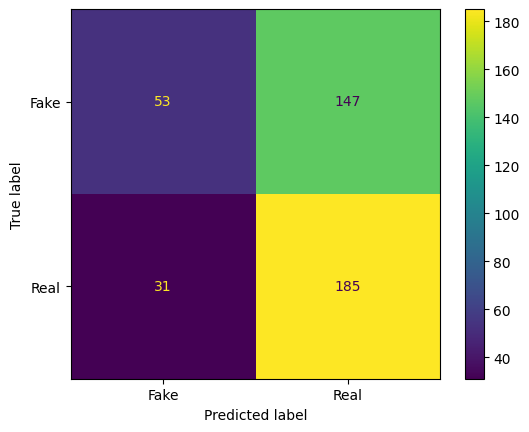

In [14]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("LSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()

**BiLSTM**

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
## Creating model Using LSTM
voc_size = embedding_matrix.shape[0]
embedding_vector_features=100
model=Sequential()
model.add(Embedding(voc_size, output_dim=embedding_vector_features, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/3
24/24 [==============================] - 4s 39ms/step - loss: 0.6372 - accuracy: 0.6534 - val_loss: 0.5401 - val_accuracy: 0.7700
Epoch 2/3
24/24 [==============================] - 0s 8ms/step - loss: 0.5472 - accuracy: 0.7503 - val_loss: 0.5002 - val_accuracy: 0.7606
Epoch 3/3
24/24 [==============================] - 0s 8ms/step - loss: 0.4863 - accuracy: 0.7799 - val_loss: 0.4094 - val_accuracy: 0.8216


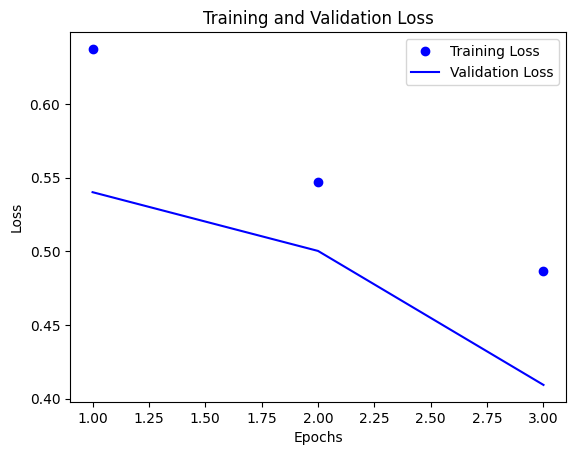

In [16]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 3)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

13/13 [==============================] - 1s 3ms/step
BiLSTM Model Accuracy :  0.5432692307692307
Precision :  0.5333333333333333
Recall :  0.9629629629629629
F1 :  0.6864686468646864
G-mean: 0.2943920288775949
Training time:  4.777135372161865
Inference time:  0.7222278118133545
              precision    recall  f1-score   support

           0       0.69      0.09      0.16       200
           1       0.53      0.96      0.69       216

    accuracy                           0.54       416
   macro avg       0.61      0.53      0.42       416
weighted avg       0.61      0.54      0.43       416



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


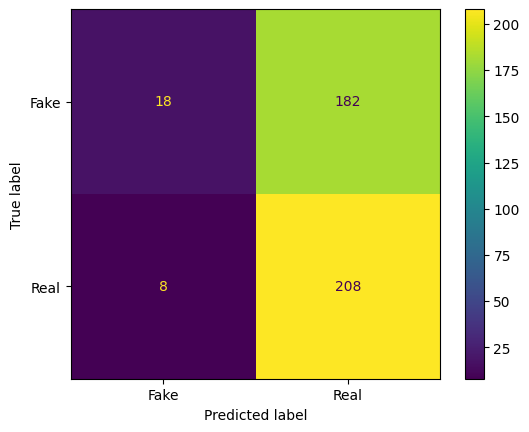

In [17]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("BiLSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()

**CNN-BiLSTM**

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
## Creating model Using LSTM
voc_size = embedding_matrix.shape[0]
embedding_vector_features=100
model=Sequential()
model.add(Embedding(voc_size, output_dim=embedding_vector_features, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Dropout(0.3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPool1D())
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPool1D())
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/3
24/24 [==============================] - 10s 45ms/step - loss: 0.6691 - accuracy: 0.6117 - val_loss: 0.6200 - val_accuracy: 0.6714
Epoch 2/3
24/24 [==============================] - 0s 7ms/step - loss: 0.6352 - accuracy: 0.6299 - val_loss: 0.5503 - val_accuracy: 0.7606
Epoch 3/3
24/24 [==============================] - 0s 8ms/step - loss: 0.5621 - accuracy: 0.7201 - val_loss: 0.4668 - val_accuracy: 0.7981


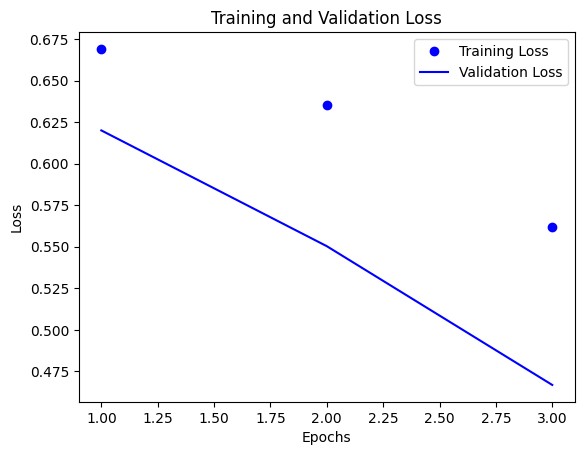

In [19]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 3)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

13/13 [==============================] - 1s 2ms/step
CNN-BiLSTM Model Accuracy :  0.5552884615384616
Precision :  0.54858934169279
Recall :  0.8101851851851852
F1 :  0.6542056074766355
G-mean: 0.47628967220784024
Training time:  9.94697904586792
Inference time:  0.7736043930053711
              precision    recall  f1-score   support

           0       0.58      0.28      0.38       200
           1       0.55      0.81      0.65       216

    accuracy                           0.56       416
   macro avg       0.56      0.55      0.52       416
weighted avg       0.56      0.56      0.52       416



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


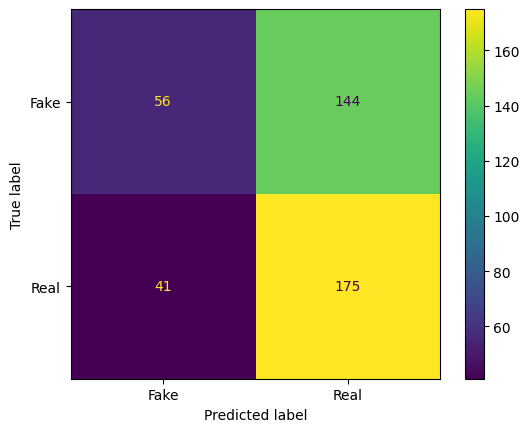

In [20]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("CNN-BiLSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()

**BERT**


In [21]:
!pip install transformers
import torch
from transformers import BertTokenizer
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.4 MB/s eta 0:00:00


In [22]:
from torch.utils.data import Dataset

class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ['train', 'val', 'test']
        self.mode = mode
        self.df = pd.read_csv(mode + '.tsv', sep='\t').fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  # BERT tokenizer

    def __getitem__(self, idx):
        if self.mode == 'test':
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
        else:
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)

        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)

        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)

        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
    
# Initialize Datasets for Transformation
trainset = FakeNewsDataset('train', tokenizer=tokenizer)
valset = FakeNewsDataset('val', tokenizer=tokenizer)
testset = FakeNewsDataset('test', tokenizer=tokenizer)

print('trainset size:' ,trainset.__len__())
print('valset size:',valset.__len__())
print('testset size: ',testset.__len__())

trainset size: 1486
valset size: 213
testset size:  416


In [23]:
sample_idx = 0

statement,label = trainset.df.iloc[sample_idx].values

tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)

print(f"""
original_statement: 
{statement}

tokens: 
{tokens}

label: {label}

--------------------

tokens_tensor: 
{tokens_tensor}

segments_tensor: 
{segments_tensor}

label_tensor: 
{label_tensor}

""")


original_statement: 
Prince to perform surprise show in Toronto http://t.co/Kj7HibxIrx http://t.co/GrkgI3n5xV

tokens: 
['[CLS]', 'prince', 'to', 'perform', 'surprise', 'show', 'in', 'toronto', 'http', ':', '/', '/', 't', '.', 'co', '/', 'k', '##j', '##7', '##hi', '##b', '##xi', '##r', '##x', 'http', ':', '/', '/', 't', '.', 'co', '/', 'gr', '##k', '##gi', '##3', '##n', '##5', '##x', '##v', '[SEP]']

label: 0

--------------------

tokens_tensor: 
tensor([  101,  3159,  2000,  4685,  4474,  2265,  1999,  4361,  8299,  1024,
         1013,  1013,  1056,  1012,  2522,  1013,  1047,  3501,  2581,  4048,
         2497,  9048,  2099,  2595,  8299,  1024,  1013,  1013,  1056,  1012,
         2522,  1013, 24665,  2243,  5856,  2509,  2078,  2629,  2595,  2615,
          102])

segments_tensor: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

label_tensor: 
0




In [24]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]

    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # Zero Padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


BATCH_SIZE = 16
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch)

In [25]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

In [26]:
from transformers import BertForSequenceClassification
from IPython.display import display, clear_output

PRETRAINED_MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

In [27]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
NUM_EPOCHS = 3
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0

    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]
        max_seq_len = 512
        tokens_tensors = tokens_tensors[:, :max_seq_len]
        segments_tensors = segments_tensors[:, :max_seq_len]
        masks_tensors = masks_tensors[:, :max_seq_len]
        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors,token_type_ids=segments_tensors, attention_mask=masks_tensors, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())

        train_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(acc = train_acc, loss = train_loss)

end_time = time.time()
training_time = end_time - start_time

device: cuda:0


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

In [28]:
torch.save(model, './best_model.pth')

BERT Model Accuracy :  0.5865384615384616
Precision :  0.5705128205128205
Recall :  0.8240740740740741
F1 :  0.6742424242424242
G-mean: 0.5214829282387339
Training time:  18.423654317855835
Inference time:  0.5603194236755371
              precision    recall  f1-score   support

           0       0.63      0.33      0.43       200
           1       0.57      0.82      0.67       216

    accuracy                           0.59       416
   macro avg       0.60      0.58      0.55       416
weighted avg       0.60      0.59      0.56       416



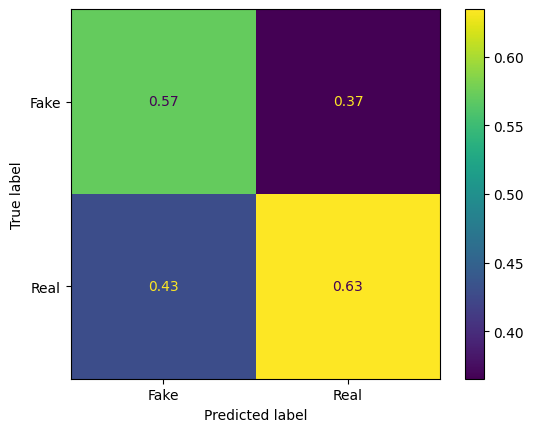

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.metrics import geometric_mean_score
true=[]
predictions=[]
start_time = time.time()
with torch.no_grad():
    model.eval()
    for data in testloader:
        if next(model.parameters()).is_cuda:
            data = [t.to(device) for t in data if t is not None]
            
        tokens_tensors, segments_tensors, masks_tensors = data[:3]
        max_seq_len = 512
        tokens_tensors = tokens_tensors[:, :max_seq_len]
        segments_tensors = segments_tensors[:, :max_seq_len]
        masks_tensors = masks_tensors[:, :max_seq_len]
        test_outputs = model(input_ids=tokens_tensors, 
                    token_type_ids=segments_tensors, 
                    attention_mask=masks_tensors)

        logits = test_outputs[0]
        _, pred = torch.max(logits.data, 1)

        labels = data[3]
        true.extend(labels.cpu().tolist())
        predictions.extend(pred.cpu().tolist())

end_time = time.time()
inference_time = end_time - start_time
cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')

accuracy = accuracy_score(true, predictions)

g_mean = geometric_mean_score(true, predictions)
print("BERT Model Accuracy : ", accuracy)
print("Precision : ", precision_score(true, predictions))
print("Recall : ", recall_score(true, predictions))
print("F1 : ", f1_score(true, predictions))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(true, predictions))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()